<a href="https://colab.research.google.com/github/Nhat-Thanh/CS114.L21/blob/main/Simple%20CNN%20Model/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.3MB 91kB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 3.2MB 43.0MB/s 
     |████████████████████████████████| 491kB 44.4MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


##***2. Import các thư viện cần thiết cho mô hình nhận diện ảnh chữ số viết tay bằng CNN.***

In [ ]:
# First, we have to import the required libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##***3. Load the MNIST data***

###***3.1. Define data dimension***

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data

img_h = img_w = 28  # MNIST images are 28x28
img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
n_classes = 10  # Number of classes, one class per digit
n_channels = 1

###***3.2. Helper functions to load the MNIST data***

In [ ]:
# Main function

def reformat(x, y):
    """
    Reformats the data to the format acceptable for convolutional layers
    :param x: input array
    :param y: corresponding labels
    :return: reshaped input and labels
    """
    img_size = int(np.sqrt(x.shape[-1]))
    num_channels = 1
    num_class = len(np.unique(np.argmax(y, 1)))

    dataset = x.reshape((-1, img_size, img_size, num_channels)).astype(np.float32)

    labels = (np.arange(num_class) == y[:, None]).astype(np.float32)

    return dataset, labels


def load_data(mode='train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        # Training data
        x_train = mnist.train.images
        y_train = mnist.train.labels
        
        # validation data
        x_validation = mnist.validation.images
        y_validation = mnist.validation.labels

        # "reformat" is a function that defined above
        x_train, _ = reformat(x_train, y_train)
        x_validation, _ = reformat(x_validation, y_validation)

        return x_train, y_train, x_validation, y_validation

    elif mode == 'test':
        # Testing data
        x_test = mnist.test.images
        y_test = mnist.test.labels
        
        x_test, _ = reformat(x_test, y_test)
    
    return x_test, y_test

One hot example: 

![onehot.png](https://raw.githubusercontent.com/Nhat-Thanh/CS114.L21/main/Simple%20CNN%20Model/one%20hot.png)

###***3.3. Load the data and display the sizes***

In [ ]:
# Now we can use the defined helper function in "train" mode which loads the train and validation images and their corresponding labels. We'll also display their sizes:

x_train, y_train, x_validation, y_validation = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_validation)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

##***4. Hyperparameters***

In [ ]:
# Hyperparameters

logs_path = "./logs"  # path to the folder that we want to save the logs for Tensorboard

lr = 0.001            # The optimization initial learning rate

epochs = 10           # Total number of training epochs

batch_size = 100      # Training batch size

display_freq = 100    # Frequency of displaying the training results

##***5. Network configuration***

In [ ]:
# Network configuration

# 1st Convolutional Layer
filter_size_1st = 5   # Convolution filters are 5 x 5 pixels.
num_filters_1st = 16  # There are 16 of these filters.
stride_1st = 1        # The stride of the sliding window

# 2nd Convolutional Layer
filter_size_2nd = 5   # Convolution filters are 5 x 5 pixels.
num_filters_2nd = 32  # There are 32 of these filters.
stride_2nd = 1        # The stride of the sliding window

# Fully-connected layer.
h1 = 128  # Number of neurons in fully-connected layer.

##***6. Create network helper functions***

###***6.1. Helper functions for creating new variables***

In [ ]:
# weight wrappers
def weight_variable(shape, name='W'):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param Shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable(name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

# Bias wrappers
def bias_variable(shape, name='b'):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param Shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, 
                          dtype=tf.float32
                          )
    
    return tf.get_variable(name, 
                           dtype=tf.float32, 
                           initializer=initial
                           )

###***6.2. Helper-function for creating a new Convolutional Layer***

In [ ]:
# Helper-function for creating a new Convolutional Layer

def conv_layer(x, filter_size, num_filters, stride, name):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_input_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_input_channel, num_filters]

        # "weight_variable" is a function that defined above
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)

        # "bias_variable" is a function that defined above
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)

        layer = tf.nn.conv2d(x, W,
                             strides=[1, stride, stride, 1],
                             padding="SAME")
        layer += b
        return tf.nn.relu(layer)

###***6.3. Helper-function for creating a new Max-pooling Layer***

In [ ]:
# Helper-function for creating a new Max-pooling Layer

def max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)

###***6.4. Helper-function for flattening a layer***

In [ ]:
# 4.4. Helper-function for flattening a layer

def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

###***6.5. Helper-function for creating a new fully-connected Layer***

In [ ]:
# Helper-function for creating a new fully-connected Layer

def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        input_dim = x.get_shape()[1]

        # "weight_variable" is a function that defined above
        W = weight_variable(shape=[input_dim, num_units])
        tf.summary.histogram('weight', W)

        # "bias_variable" is a function that defined above
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)

        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        
        return layer

##***7. Network graph***

###***7.1. Placeholders for the inputs (x) and corresponding labels (y)***

In [ ]:
# Placeholders for the inputs (x) and corresponding labels (y)

with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_h, img_w, n_channels], name='X')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

###***7.2. Create the network layers***

In [ ]:
# Create the network layers

conv_1st = conv_layer(x, filter_size_1st, num_filters_1st, stride_1st, name='conv_1st')          # part 5 and 6.2

pool_1st = max_pool(conv_1st, ksize=2, stride=2, name='pool_1st')                                # 6.3

conv_2nd = conv_layer(pool_1st, filter_size_2nd, num_filters_2nd, stride_2nd, name='conv_2nd')   # part 5 and 6.2

pool_2nd = max_pool(conv_2nd, ksize=2, stride=2, name='pool_2nd')                                # 6.3

layer_flat = flatten_layer(pool_2nd)                                                             # 6.4

fc_1st = fc_layer(layer_flat, h1, 'FC1', use_relu=True)                                          # part 5 and 6.5 

output_logits = fc_layer(fc_1st, n_classes, 'OUT', use_relu=False)                               # part 6.5

###***7.3. Define the loss function, optimizer, accuracy, and predicted class***

In [ ]:
# Define the loss function, optimizer, accuracy, and predicted class

with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    
    tf.summary.scalar('loss', loss)

    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam-op').minimize(loss)
    
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    
    tf.summary.scalar('accuracy', accuracy)
    
    with tf.variable_scope('Prediction'):
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



###***7.4. Initialize all variables and merge the summaries***

In [ ]:
# Initialize the variables
init = tf.global_variables_initializer()

# Merge all summaries
merged = tf.summary.merge_all()

##***8. Train***

Tạo một hàm hỗ trợ cho việc xáo trộn thứ tự data

In [ ]:
# Helper function for Randomization
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

In [ ]:
# Helper function for get a next batch

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

Train data

In [ ]:
# Train

session = tf.InteractiveSession()
session.run(init)
global_step = 0

# logs_path = "./logs"
# logs_path was definded at part 4
summary_writer = tf.summary.FileWriter(logs_path, session.graph) 

# Number of training iterations in each epoch
num_training_iteration = int(len(y_train) / batch_size)


# epoch = 10
# batch_size = 100
# all of them were definded at part 4
for epoch in range(epochs): 
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)  #
    for iteration in range(num_training_iteration):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size

        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        session.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, accuracy_batch, summary_training = session.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_training, global_step)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".format(iteration, loss_batch, accuracy_batch))

    # Run validation after every epoch
    feed_dict_validation = {x: x_validation, y: y_validation}
    loss_validation, accuracy_validation = session.run([loss, accuracy], feed_dict=feed_dict_validation)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".format(epoch + 1, loss_validation, accuracy_validation))
    print('---------------------------------------------------------')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training epoch: 1
iter   0:	 Loss=2.30,	Training Accuracy=15.0%
iter 100:	 Loss=0.32,	Training Accuracy=91.0%
iter 200:	 Loss=0.36,	Training Accuracy=91.0%
iter 300:	 Loss=0.16,	Training Accuracy=90.0%
iter 400:	 Loss=0.13,	Training Accuracy=98.0%
iter 500:	 Loss=0.11,	Training Accuracy=98.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.11, validation accuracy: 96.6%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.09,	Training Accuracy=96.0%
iter 100:	 Loss=0.18,	Training Accuracy=93.0%
iter 200:	 Loss=0.05,	Training Accuracy=99.0%
iter 300:	 Loss=0.08,	Training Accuracy=96.0%
iter 400:	 Loss=0.12,	Training Accuracy=95.0%
iter 500:	 Loss=0.08,	Training Accuracy=98.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.07, validation accuracy: 97.9%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.05,	Training Accuracy=98

##***9. Test***

###***9.1. Hàm vẽ các bức ảnh dự đoán đúng và sai***

In [ ]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(5, 5, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.squeeze(images[i]), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)


def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:25],
                cls_true=cls_true[0:25],
                cls_pred=cls_pred[0:25],
                title=title)

###***9.2 Test với các tham số sau khi train***

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.04, test accuracy: 98.9%
---------------------------------------------------------


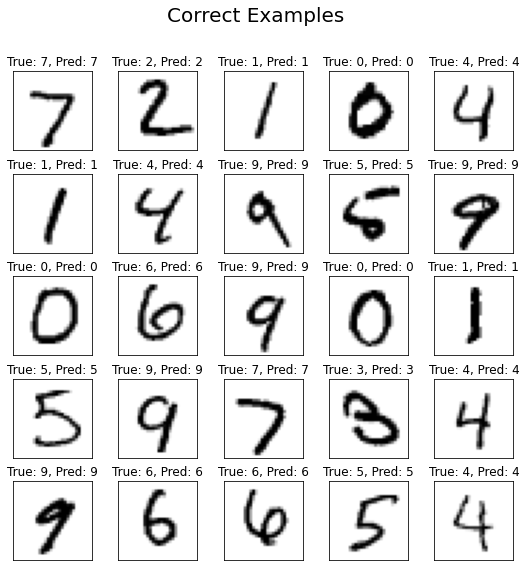

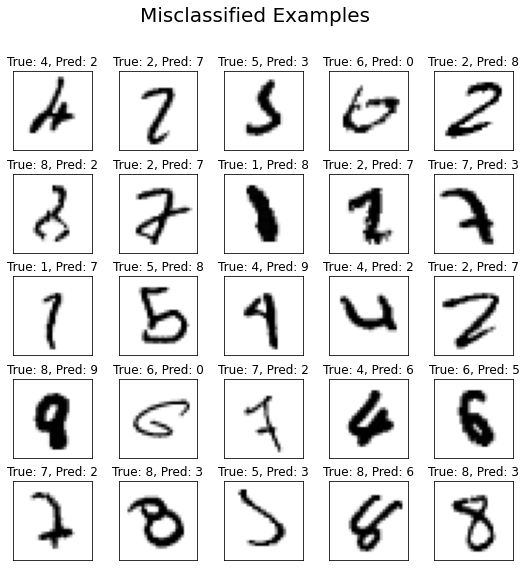

In [ ]:
# Test the network when training is done
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test, y: y_test}
loss_test, accuracy_test = session.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, accuracy_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = session.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test, cls_true, cls_pred, title='Misclassified Examples')
plt.show()